# Cyft Data Investigation

Goal:

    Create target
    EDA
    Create a Model


#### Description:

_30-Day All-Cause Hospital Readmissions_ is a quality measure that many healthcare organizations use to track their performance. Lower readmission rates indicate better patient outcomes, while higher ones tend to indicate system problems that are negatively impacting patients. The goal of this exercise is to analyze a dataset that simulates hospitalizations for a geriatric patient population in 2015 and 2016 to predict __if a patient is likely to have a readmission based on the information available at the time of their initial admission.__

You have 3 hours to complete the exercise. If you don't get through all the objectives, that's OK. After 3 hours, please finish what you're working on and send in whatever code, analyses, and visualizations (such as images) you have available. Include comments documenting any assumptions you've made as well as other ideas you would have tried if you had more time.

Feel free to use the language and statistical/machine learning libraries that you are most comfortable with, and ask questions along the way if any clarifications are necessary.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
admit = pd.read_csv('../Cyft/readmissions/admissions.csv')
claims = pd.read_csv('../Cyft/readmissions/claims.csv')

#### Data Dictionary

  * admissions.csv
    * Patient - a unique patient identifier string.
    * AdmitDate - start date of hospital admission (yyyy-MM-dd formatted).
    * LOS - length of hospital stay for the admission in days.

  * claims.csv
    * Patient - a unique patient identifier string.
    * AdmitDate - start date of hospital admission (yyyy-MM-dd formatted).
    * Age - patient's current age at time of admission.
    * Gender - single character gender value for the patient (limited to 2 values for simplicity).
    * PrimaryDx - the primary diagnosis code for the patient.
    * Dx2 - the secondary diagnosis code for the patient (nullable).
    * Dx3 - the tertiary diagnosis code for the patient (nullable).
    * PastPCPVisits - the count of primary care physician visits the patient had in the 12 months prior to admission.

In [4]:
admit.head()

,Patient,AdmitDate,LOS
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,7
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,7
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,7
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,5


In [5]:
claims.head()

,Patient,AdmitDate,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,74,M,N18,T88,NaN,19
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,71,F,N18,R39,@NA,3
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,85,M,E11,R39,NaN,10
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,67,F,N18,F05,NaN,8
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,78,F,A41,T88,J18,13


#### Initial Look

There are two overlapping columns, patient ID and admitdate. The csvs map 1:1. AdmitDate will be more useful converted to a datetime type. 

In [6]:
print('admit: {} rows and {} columns'.format(*admit.shape))
print('claims: {} rows and {} columns'.format(*claims.shape))

admit: 5849 rows and 3 columns
claims: 5849 rows and 8 columns


In [7]:
full = pd.merge(admit,claims,on=['Patient','AdmitDate'])
full['AdmitDate'] = pd.to_datetime(full['AdmitDate'])
full.head()

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9,74,M,N18,T88,NaN,19
1,61e049c2-08e8-469a-a1e0-808d99c084fd,2015-03-23,7,71,F,N18,R39,@NA,3
2,19bccbe8-0bc7-4dd5-8066-de5bd76acdff,2015-11-07,7,85,M,E11,R39,NaN,10
3,520d5129-fa07-45a3-9108-f6fa895c0169,2015-01-24,7,67,F,N18,F05,NaN,8
4,e7af2ac0-bd25-4cfe-a6f2-e6642db02f64,2015-09-08,5,78,F,A41,T88,J18,13


In [8]:
print('full: {} rows and {} columns'.format(*full.shape))

full: 5849 rows and 9 columns


In [9]:
#full.set_index('AdmitDate')

#### Null Values

Can be:
    
    empty strings or values
    NaN
    @NA

In [10]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5849 entries, 0 to 5848
Data columns (total 9 columns):
Patient          5849 non-null object
AdmitDate        5849 non-null datetime64[ns]
LOS              5849 non-null int64
Age              5849 non-null int64
Gender           5849 non-null object
PrimaryDx        5849 non-null object
Dx2              5849 non-null object
Dx3              3883 non-null object
PastPCPVisits    5849 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 457.0+ KB


In [11]:
full_nan = full.replace('@NA',np.NaN) # replace @NA
full_nan = full_nan.replace('',np.NaN) # didn't find any empty strings

Looks like feature Dx3 is the only one with null values but they are 67% of the column which makes it unrealistic to impute. 

This makes sense as it is less likely to have a third diagnosis at admission time as a primary or secondary. Have to keep an eye on it down the line. For now leave as ''

In [12]:
full_nan.isnull().sum() / full_nan.shape[0]

Patient          0.00000
AdmitDate        0.00000
LOS              0.00000
Age              0.00000
Gender           0.00000
PrimaryDx        0.00000
Dx2              0.00000
Dx3              0.66849
PastPCPVisits    0.00000
dtype: float64

In [13]:
full = full.replace('@NA',np.NaN) # replace @NA
full = full.replace('',np.NaN) # didn't find any empty strings
full = full.replace(np.NaN,'')

#### Determine Patients with Readmissions and create <=30Days target column

Any patient id which shows up more than once is considered a readmission. New binary column is created since this is our target variable.

In [14]:
print('There are {} patients readmitted in the dataset'.format(np.sum(full['Patient'].value_counts()>1)))


There are 1932 patients readmitted in the dataset


In [15]:
full['Readmitted'] = full.groupby(['Patient'])['Patient'].transform('count')
full['Readmitted'] = full['Readmitted'].map({2:1,1:0})

In [16]:
full[full['Readmitted'] == 1].groupby(['Patient']).diff()['AdmitDate'].tail()

5844    6 days
5845   31 days
5846   40 days
5847   36 days
5848   32 days
Name: AdmitDate, dtype: timedelta64[ns]

In [17]:
full['DaysSinceAdmission'] = full[full['Readmitted'] == 1].groupby(['Patient']).diff()['AdmitDate']

In [18]:
full['<=30Days'] = (full['DaysSinceAdmission'] <= pd.Timedelta('30 days')).astype(np.int)

In [19]:
full.tail()

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits,Readmitted,DaysSinceAdmission,<=30Days
5844,641acfac-9bd1-4864-be0a-52d4bfc78ef9,2016-03-14,7,75,M,A41,I51,,15,1,6 days,1
5845,e152df3f-69a5-4ad4-9cf0-a3b7a6b9d4d8,2016-12-20,5,86,M,E11,R41,,17,1,31 days,0
5846,a45e1bab-df5f-4078-b938-31f920e2f765,2016-09-18,9,78,M,A41,I51,R05,14,1,40 days,0
5847,963fdb5d-bfe6-47c9-84c8-6456ce0fd093,2017-01-19,6,81,M,J44,F05,,17,1,36 days,0
5848,a2940e72-8185-4944-8257-6c440d8aa374,2016-09-11,8,77,F,I50,R39,,11,1,32 days,0


#### Correct the target column

I was looking at the characteristics of the _readmission_ trying to predict itself when I should have flagged the first visit as __will_be_readmitted__ to use its characteristics to predict a readmission.

In [20]:
full[['WillBe<=30Days']] = full[full['Readmitted'] == 1].groupby('Patient').shift(-1)[['<=30Days']].fillna(0).astype(np.int)


In [927]:
full[full['Patient'] == '5e982461-47d7-4ae9-ac75-d1f31acaee81']

,Patient,AdmitDate,LOS,Age,Gender,PrimaryDx,Dx2,Dx3,PastPCPVisits,Readmitted,DaysSinceAdmission,<=30Days,WillBe<=30Days
0,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-12,9,74,M,N18,T88,,19,1,NaT,0,1.0
4304,5e982461-47d7-4ae9-ac75-d1f31acaee81,2015-09-22,5,74,M,J44,R41,H91,21,1,10 days,1,0.0


Confirm that the distributions are the same, since they should be. Turns out I need to fill NaNs with zeros

In [21]:
full['<=30Days'].value_counts()

0    4471
1    1378
Name: <=30Days, dtype: int64

In [22]:
full['WillBe<=30Days'].value_counts()

0.0    2486
1.0    1378
Name: WillBe<=30Days, dtype: int64

In [23]:
full['WillBe<=30Days'] = full['WillBe<=30Days'].fillna(0)

In [24]:
print('There is a {:.2f}% chance of being readmitted within 30 days'.format(100*full['WillBe<=30Days'].mean()))


There is a 23.56% chance of being readmitted within 30 days


#### Reset the <=30Days column to correct values

Since the rest of the notebook uses '<=30Days' as the target, I'm going to overwrite it with 'WillBe<=30Days'

In [25]:
full['<=30Days'] = full['WillBe<=30Days']
full.drop('WillBe<=30Days',axis=1,inplace=True)

#### Summary statistics of features

Confirm no duplicates. Would not want to be incorrectly counting. Take a look at distributions of each feature. This can be done for each column by looking at all columns value counts. This isn't always manageable but with a small dataset like this it is helpful. 

In [26]:
full.duplicated().sum()

0

In [27]:
for col in full.columns:
    print(full[col].value_counts())

519aa967-1efd-4324-a2bd-d2bc10b6d1f1    2
5b491bfa-d25f-42cd-91f7-86e051a80eb2    2
60d1edae-6c89-413d-a89f-d647d1c54fd4    2
45b8931f-4933-4117-8050-7114ff79488d    2
2688cccb-2fd0-4a9b-9d13-d7d879681088    2
66b902a6-1c81-4449-b341-134f71f9eaef    2
f2a8e0d4-f42a-406f-8605-2d11fe9d5cf1    2
ad3dcb5a-4a6e-4f48-b4c4-bb3a5c5ef632    2
5e0e72d1-3e35-4289-9e54-f449d87d05b8    2
5c195cc9-7fe6-4bbe-8e19-493d80c704a8    2
a18c7486-7324-4d4d-b34e-70f999781464    2
010ceb21-cdae-4eec-9e82-571f52784ba1    2
616314aa-03b7-4f0e-a92e-cfec6d8f6f94    2
8910ce4c-ecd8-44dd-9f4e-55481d73f244    2
d4397339-8b92-4fc6-8d16-1fc05fb49f2c    2
7423a780-f3ca-4a4f-800e-299caa3829c9    2
b174bcf0-69f8-4d80-a2ea-4494c6b9ec45    2
391546c9-d4d0-4b61-ab1e-724d04b70392    2
c439eaff-e429-4247-88dd-e65fd26a2a77    2
4f655ff7-9ee2-4977-b859-6b5f7edd3545    2
fed5aaf4-18bd-4ae9-8062-b169a864b359    2
a103d35c-0346-4a1d-acf4-8a4149ed142d    2
a89b1496-421a-4023-9c0d-cf41dfd5db4c    2
9f18e1e3-089a-4210-9eee-d0ef0671b3

In [28]:
print('Columns:\n\t'+'\n\t'.join(map(str,[col for col in full.columns])))

Columns:
	Patient
	AdmitDate
	LOS
	Age
	Gender
	PrimaryDx
	Dx2
	Dx3
	PastPCPVisits
	Readmitted
	DaysSinceAdmission
	<=30Days


Theres a uniform distribution in of data across all the dates in the dataset with the months in 2017 trailing off.

2017 dates won't be used in the evaluation of the model so this will not affect us

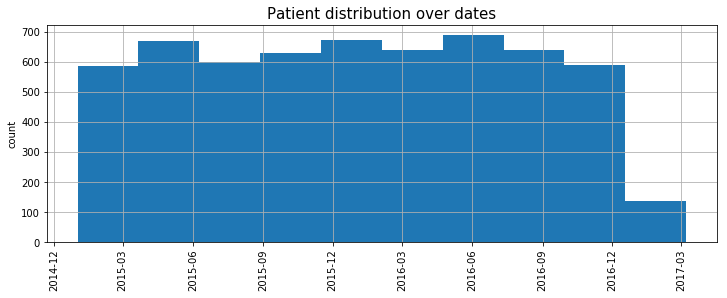

In [29]:
full['AdmitDate'].hist(xrot=90,figsize=(12,4))
plt.title('Patient distribution over dates',size=15)
plt.ylabel('count')

There is a ~normal distribution of Length of Stay centered around 6 days. There is a broad spread with a min of 1 and a max of 15 however 50% of the data sits in buckets days 5,6,7 days long.

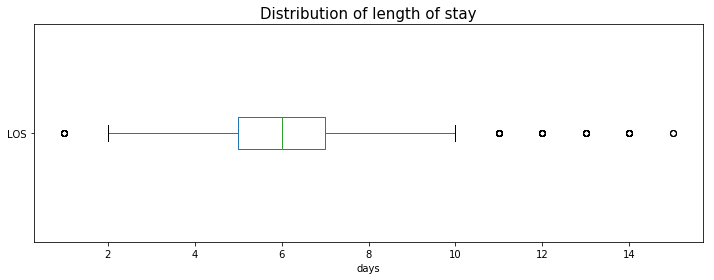

In [30]:
full['LOS'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('days')
plt.title('Distribution of length of stay',size=15)

In [31]:
full['LOS'].unique().shape[0]

15

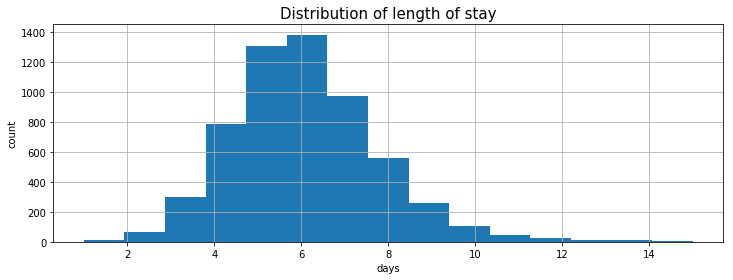

In [32]:
full['LOS'].hist(bins=15,figsize=(12,4))
plt.title('Distribution of length of stay',size=15)
plt.xlabel('days')
plt.ylabel('count')

Age is a normal distribution with a clipping at the end probably rounding ages over 90 to the age 90. Majority sit between 72-80 yrs old.

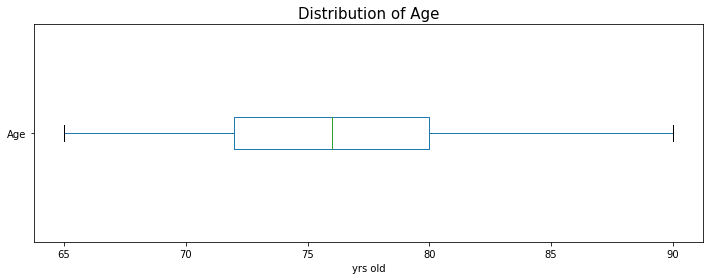

In [33]:
full['Age'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('yrs old')
plt.title('Distribution of Age',size=15)

In [34]:
full['Age'].unique().shape[0]

26

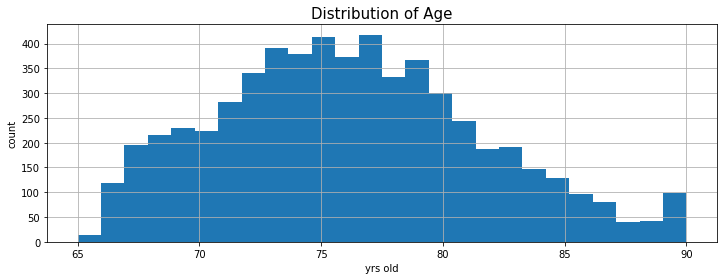

In [35]:
full['Age'].hist(bins=26,figsize=(12,4))
plt.title('Distribution of Age',size=15)
plt.xlabel('yrs old')
plt.ylabel('count')

Even split of genders, though slightly more female as would be expected by their long expected lifespan

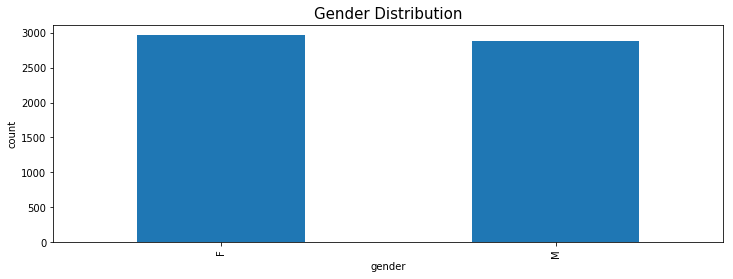

In [36]:
full['Gender'].value_counts().plot(kind='bar',figsize=(12,4))
plt.title('Gender Distribution',size=15)
plt.xlabel('gender')
plt.ylabel('count')

There are 3 diagnoses columns so lets take a look at all together. 

PrimaryDx:
    - N39 has very few occurances
    
Dx2:
    - M54 has very few occurances
    
Dx3:
    - Exluding the missing data, all Dxs look to have between 200-500 occurances


In [37]:
Dx_cols = ['PrimaryDx','Dx2','Dx3']

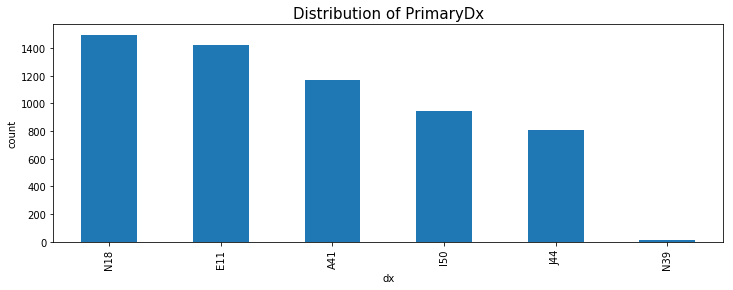

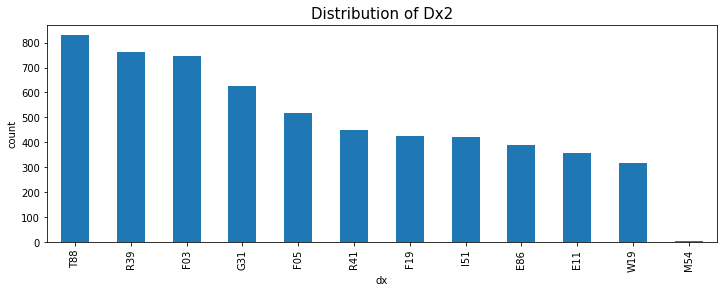

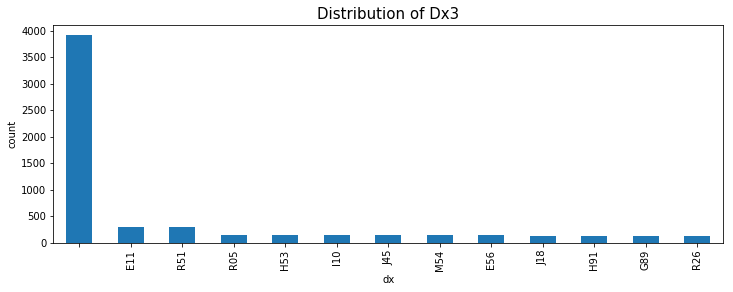

In [38]:
for col in Dx_cols:
    bins = full[col].unique().shape[0]
    #full[col].hist(bins=bins,figsize=(12,4))
    full[col].value_counts().plot(kind='bar',figsize=(12,4))
    plt.title('Distribution of {}'.format(col),size=15)
    plt.xlabel('dx')
    plt.ylabel('count')
    plt.figure()

Past visits are all centered around 11 with 50% of the data between 7 adn 15 visits.

In [39]:
full['PastPCPVisits'].describe()

count    5849.000000
mean       11.123782
std         5.373314
min         1.000000
25%         7.000000
50%        11.000000
75%        15.000000
max        34.000000
Name: PastPCPVisits, dtype: float64

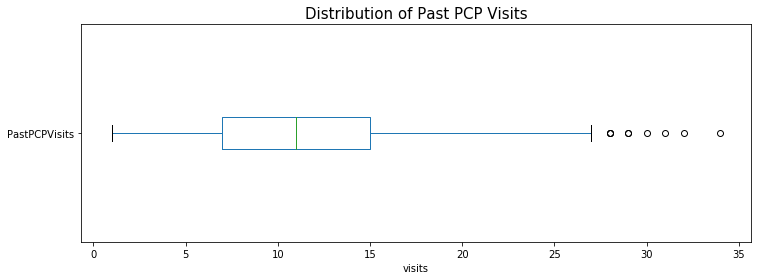

In [40]:
full['PastPCPVisits'].plot(kind='box',figsize=(12,4),vert=False)
plt.xlabel('visits')
plt.title('Distribution of Past PCP Visits',size=15)

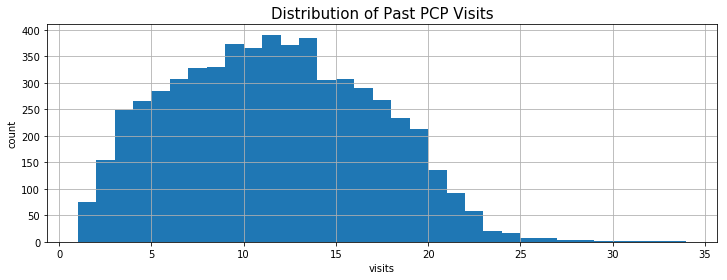

In [41]:
bins = full['PastPCPVisits'].unique().shape[0]
full['PastPCPVisits'].hist(bins=bins,figsize=(12,4))
plt.title('Distribution of Past PCP Visits'.format(col),size=15)
plt.xlabel('visits')
plt.ylabel('count')
plt.figure()

#### Take a quick look at which diagnoses, ages, and past visits lead to the highest readmittance

Baseline rate is 66% readmitted but only 24% of those are readmitted within less than 30 days. We are therefore looking for combinations which lead to a higher readmitted rate than 24%.

In [42]:
full['<=30Days'].mean()

0.23559582834672593

In [43]:
full.groupby(['PrimaryDx'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
PrimaryDx,,,
N39,6.0,10,0.600000
E11,503.0,1422,0.353727
N18,504.0,1498,0.336449
A41,260.0,1171,0.222032
I50,84.0,943,0.089077
J44,21.0,805,0.026087


In [44]:
full.groupby(['Dx2'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Dx2,,,
M54,4.0,5,0.800000
T88,348.0,830,0.419277
F03,288.0,748,0.385027
R39,271.0,764,0.354712
G31,182.0,626,0.290735
F05,126.0,517,0.243714
R41,78.0,448,0.174107
F19,41.0,425,0.096471
I51,20.0,423,0.047281


In [45]:
full.groupby(['Dx3'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Dx3,,,
I10,45.0,144,0.312500
R51,74.0,287,0.257840
E11,77.0,299,0.257525
J18,33.0,132,0.250000
H91,32.0,129,0.248062
,915.0,3910,0.234015
G89,29.0,125,0.232000
J45,31.0,136,0.227941
R05,32.0,147,0.217687


Age:
    - There is a sharp drop off in readmittance rate in the low to mid 70s
    - Late 70s and onward there is a 6% higher chance that you'll be readmitted

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


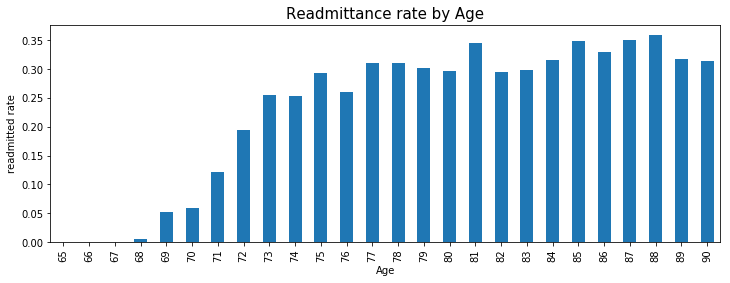

In [46]:
full.groupby(['Age'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'})['mean'].plot(kind='bar',figsize=(12,4))
plt.title('Readmittance rate by Age',size=15)
plt.ylabel('readmitted rate')

In [47]:
full.groupby(['Age'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,sum,count,mean
Age,,,
88,14.0,39,0.358974
87,28.0,80,0.350000
85,45.0,129,0.348837
81,84.0,244,0.344262
86,32.0,97,0.329897
89,13.0,41,0.317073
84,46.0,146,0.315068
90,31.0,99,0.313131
77,130.0,418,0.311005


/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


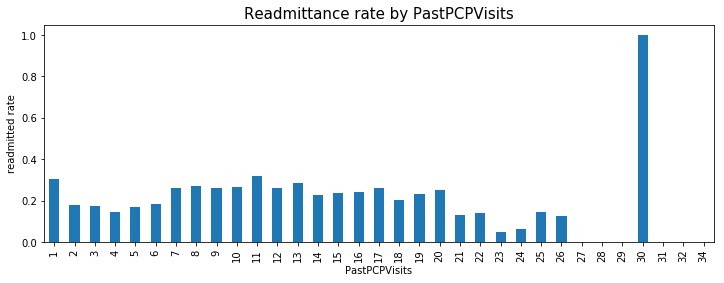

In [50]:
full.groupby(['PastPCPVisits'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'})['mean'].plot(kind='bar',figsize=(12,4))
plt.title('Readmittance rate by PastPCPVisits',size=15)
plt.ylabel('readmitted rate')

#full.groupby(['PastPCPVisits'])['<=30Days'].agg({'sum':'sum','count':'count','mean':'mean'}).sort_values(by='mean',ascending=False)


#### Split into Train, Test datasets

There are no variables which are ordinal which would be need different formatting so create onehot encodings of categorical variables.  

In [53]:
full_orig = full.copy()

full = full.set_index('AdmitDate')

for col in [col for col in full.columns if full[col].dtype == 'object' and 'Patient' not in col]:
    dummies = pd.get_dummies(full[col],prefix=col)
    full.drop(col,axis=1,inplace=True)
    full = pd.concat([full,dummies],axis=1)    

In [61]:
print('Onehot encoding converted {} cols into {} cols'.format(full_orig.shape[1],full.shape[1]))

Onehot encoding converted 12 cols into 40 cols


In [58]:
train = full['2015']
test = full['2016']

In [59]:
print('train: {} rows and {} columns'.format(*train.shape))
print('test: {} rows and {} columns'.format(*test.shape))

train: 2856 rows and 40 columns
test: 2938 rows and 40 columns


In [60]:
X_train = train.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_train = train['<=30Days']
X_test = test.drop(['Patient','Readmitted','DaysSinceAdmission','<=30Days'],axis=1)
y_test = test['<=30Days']

#### Simple Models

This is a binary classification problem so usually start with a simple logistic regression model. I'm going to use the f1_score which is a mixture of precision and recall to evaluate which model does better. This will lead to a more stable classifier than using accuracy or precision or recall alone due to the imbalanced positive class we're trying to predict which is about 1:4.

Neither are much better than the baseline accuracy, but at least they aren't worse! With a little work we should be able to impove these accuracies.

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.cross_validation import cross_val_score

/Users/xbno/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [83]:
print('Baseline accuracy is {:.02f}'.format(100*(1-full_orig['<=30Days'].mean())))

Baseline accuracy is 76.44


In [87]:
folds = 10
lr = LogisticRegression()
print('Logistic Regression accuracy of {:.02f} across {} folds'.format(100*cross_val_score(lr,X_train,y_train,cv=folds).mean(),folds))
print('Logistic Regression f1 score of {:.02f} across {} folds'.format(cross_val_score(lr,X_train,y_train,cv=folds,scoring='f1').mean(),folds))
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

Logistic Regression accuracy of 78.33 across 10 folds
Logistic Regression f1 score of 0.45 across 10 folds


In [65]:
confusion_matrix(y_test,lr_pred)

array([[2085,  174],
       [ 425,  254]])

In [88]:
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
print('Random Forest accuracy of {:.02f} across {} folds'.format(100*cross_val_score(rf,X_train,y_train,cv=folds).mean(),folds))
print('Random Forest f1 score of {:.02f} across {} folds'.format(cross_val_score(rf,X_train,y_train,cv=folds,scoring='f1').mean(),folds))
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

Random Forest accuracy of 77.17 across 10 folds
Random Forest f1 score of 0.48 across 10 folds


In [971]:
confusion_matrix(y_test,rf_pred)

array([[2070,  189],
       [ 457,  222]])

#### Feature Importance

Taking a look at the coeficients and feature importance of both Logistic Regression and Random Forest can help us understand which features are most important to each model's decision. 

In [108]:
from sklearn.preprocessing import normalize, StandardScaler

In [195]:
lr_coefs = pd.DataFrame(X_train.columns,lr.coef_[0]).reset_index()
lr_coefs.rename(columns={'index':'lr coef',0:'feat'},inplace=True)
lr_coefs['lr coef'] = lr_coefs['lr coef'].abs()

rf_imps = pd.DataFrame(X_train.columns,rf.feature_importances_).reset_index()
rf_imps.rename(columns={'index':'rf imp',0:'feat'},inplace=True)

In [196]:
both_imps = pd.merge(lr_coefs,rf_imps,on=['feat'])

both_imps.set_index('feat',inplace=True)

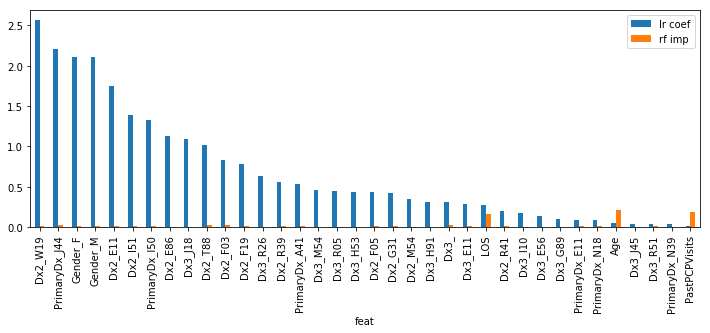

In [199]:
both_imps.sort_values(by='lr coef',ascending=False).plot(kind='bar',figsize=(12,4))

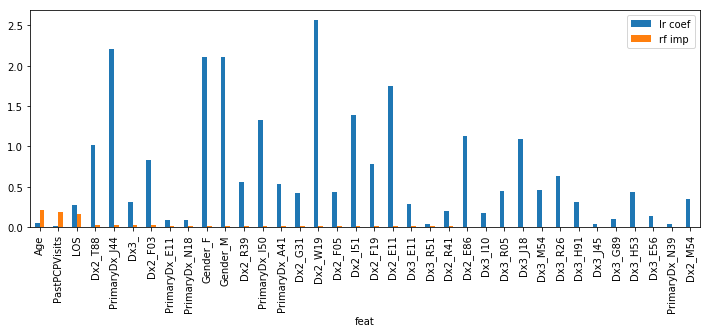

In [200]:
both_imps.sort_values(by='rf imp',ascending=False).plot(kind='bar',figsize=(12,4))

In [201]:
set(lr_coefs.sort_values(by='lr coef',ascending=False).head(10)['feat']).intersection(rf_imps.sort_values(by='rf imp',ascending=False).head(10)['feat'])


{'Dx2_T88', 'Gender_F', 'PrimaryDx_J44'}

In [296]:
top = 20
top_feats = set(list(rf_imps.sort_values(by='rf imp',ascending=False).head(top)['feat'])+list(lr_coefs.sort_values(by='lr coef',ascending=False).head(top)['feat']))


In [297]:
top_feats

{'Age',
 'Dx2_E11',
 'Dx2_E86',
 'Dx2_F03',
 'Dx2_F05',
 'Dx2_F19',
 'Dx2_G31',
 'Dx2_I51',
 'Dx2_R39',
 'Dx2_T88',
 'Dx2_W19',
 'Dx3_',
 'Dx3_H53',
 'Dx3_J18',
 'Dx3_M54',
 'Dx3_R05',
 'Dx3_R26',
 'Gender_F',
 'Gender_M',
 'LOS',
 'PastPCPVisits',
 'PrimaryDx_A41',
 'PrimaryDx_E11',
 'PrimaryDx_I50',
 'PrimaryDx_J44',
 'PrimaryDx_N18'}

#### Investigate distributions based on counts/readmitted rates

Most of our feature importances are primary/secondary diagnoses so lets take a look at the distribution of these in terms of the target variable. 

#### W19 and J44
These both make sense looking at the distributions vs the readmitted rate. W19 has no readmissions while J44 has a very small number

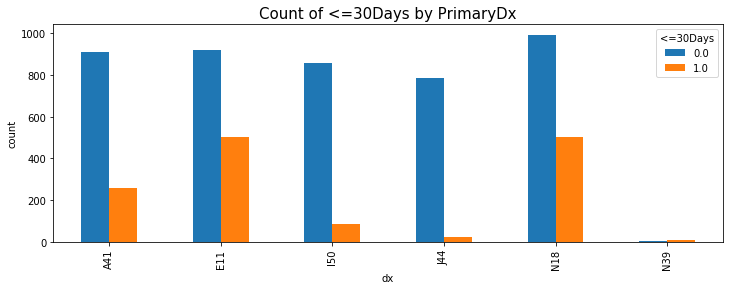

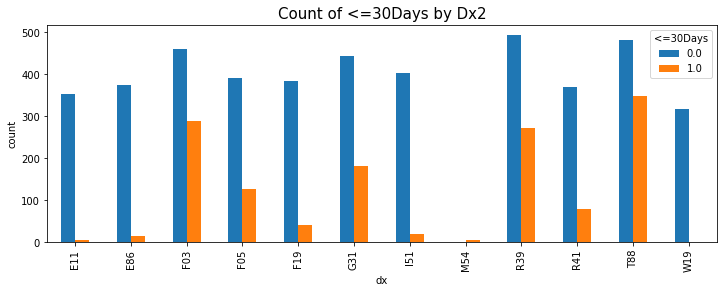

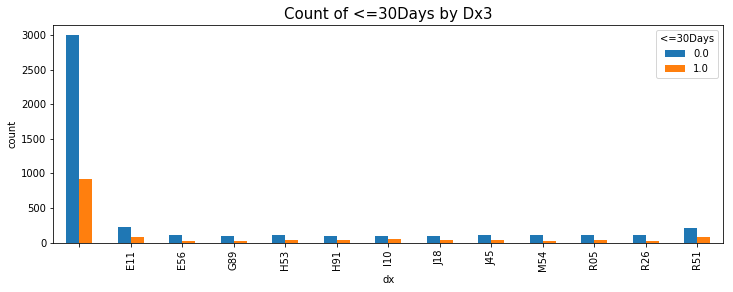

In [208]:
target = '<=30Days'
for col in Dx_cols:
    full_orig.groupby([col])[target].value_counts().unstack().plot(kind='bar',figsize=(12,4))
    plt.title('Count of {} by {}'.format(target,col),size=15)
    plt.xlabel('dx')
    plt.ylabel('count')
    plt.figure()

My hypothesis would be that having certain combinations of diagnoses would indicate worse conditions than others, so graph the combinations here by choosing the features to combine.

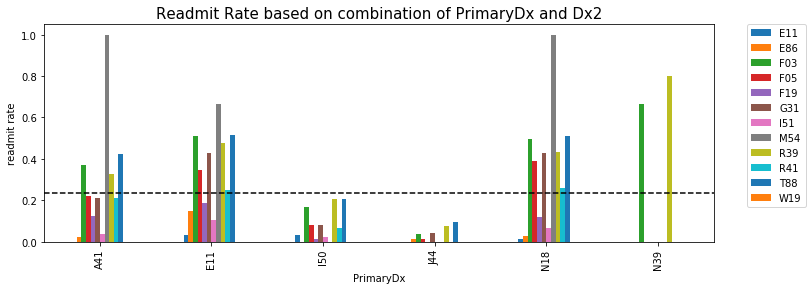

In [210]:
feat1 = 'PrimaryDx'
feat2 = 'Dx2'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

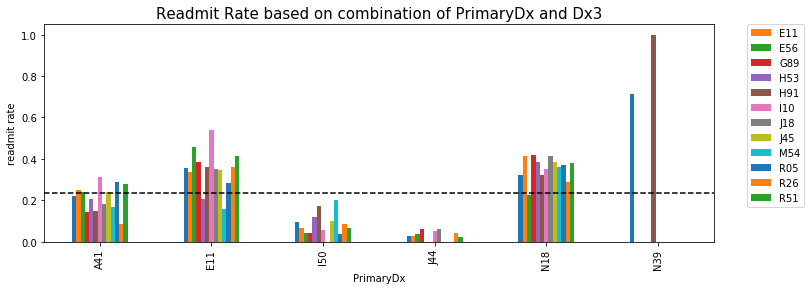

In [211]:
feat1 = 'PrimaryDx'
feat2 = 'Dx3'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

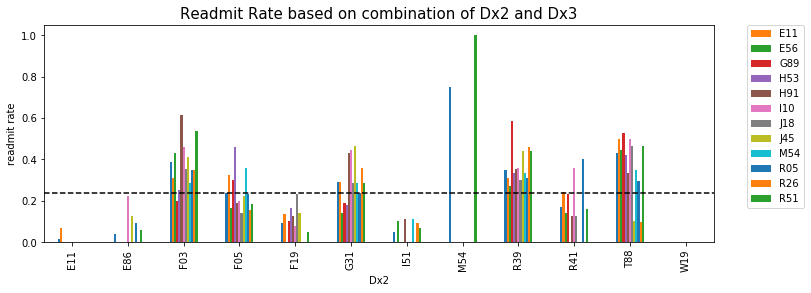

In [212]:
feat1 = 'Dx2'
feat2 = 'Dx3'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Ideas for feature creation

1. create month feature - hypothesis winter would bring more readmits. possibly make it ordinal? summer = 1, fall+spring = 2, winter = 3
    - binning doesn't seem necessary, but this feature may be helpful
2. look into combination of primary 2ndary dignoses
    - will create a very sparse dataset when onehot encoded
5. drop gender?
    - pass - rf indicated it was an important feature
6. find out what the diagnoses actually are, infer..
    - what next? 

#### Month Admit

Not as big of a difference between months as I thought. Still will include, perhaps certain ailments arise in certain months and this feature will help distinguish when they're more concerning.

__J44__ is more prevalent in the winter months

In [238]:
def add_month_feat(df):
    df['MonthAdmit'] = df['AdmitDate'].apply(lambda x: x.month)
    return df

In [239]:
full_orig = add_month_feat(full_orig)

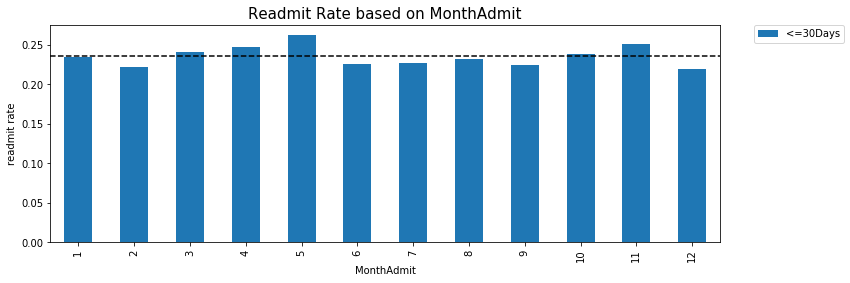

In [240]:
full_orig.groupby(['MonthAdmit'])['<=30Days'].mean().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on {}'.format(feat1),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

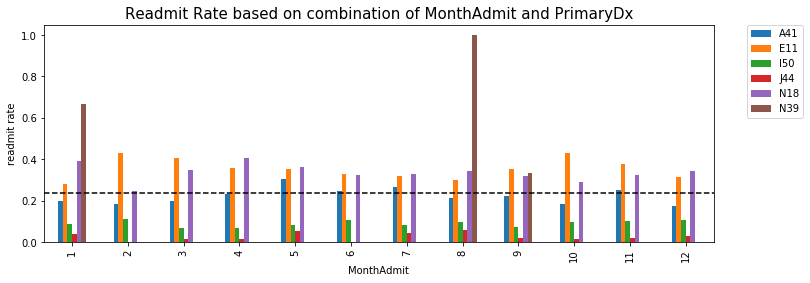

In [236]:
feat1 = 'MonthAdmit'
feat2 = 'PrimaryDx'
pop_avg = full_orig['<=30Days'].mean()
full_orig.groupby([feat1,feat2])['<=30Days'].mean().unstack().plot(kind='bar',figsize=(12,4))
plt.ylabel('readmit rate')
plt.title('Readmit Rate based on combination of {} and {}'.format(feat1,feat2),size=15)
plt.axhline(y=pop_avg, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Combos of PrimaryDx, Dx2, Dx3

Perhaps this is a bad idea. I'll be able to tell once I add run it through a model.

In [241]:
def add_combined_dx_feats(full_orig):
    full_orig['PrimaryDx_Dx2'] = full_orig['PrimaryDx']+full_orig['Dx2']
    full_orig['PrimaryDx_Dx3'] = full_orig['PrimaryDx']+full_orig['Dx3']
    full_orig['Dx2_Dx3'] = full_orig['Dx2']+full_orig['Dx3']
    return full_orig

In [242]:
full_orig = add_combined_dx_feats(full_orig)

#### Bin/PCA Ages/PCPVisits

After getting a refresher on binning continuous variables, I'm more inclined to do PCA on PastPCPVisits and Age than to bin each. 

In addition, turns out that once scaling and running PCA, the explained variance of the three columns is nearly evenly distributed between each. It doesn't seem like this will be helpful to our models.

In [279]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [286]:
#scaled pca
= PCA(n_components=3)
scaled_feats = StandardScaler().fit_transform(full_orig[['PastPCPVisits','Age','LOS']])
pcs = pd.DataFrame(pca.fit_transform(scaled_feats))

In [292]:
# #unscaled pca
# pcs = pd.DataFrame(pca.fit_transform(full_orig[['PastPCPVisits','Age','LOS']]))
# pcs = pd.DataFrame(pca.fit_transform(full_orig[['PastPCPVisits','Age','LOS']]))

In [293]:
pcs.columns = ['pc1','pc2','pc3']

In [294]:
pca.explained_variance_ratio_

array([ 0.39591659,  0.32702664,  0.27705677])

In [295]:
pca.components_

array([[ 0.61949352,  0.68643909,  0.38082693],
       [-0.4619068 , -0.07350404,  0.8838774 ],
       [ 0.63472032, -0.72346287,  0.27153561]])

#### Human Readable Diagnoses (ICD-10 Codes)

Perhaps it won't add much to the evaluation of features in the model but it would be nice to understand what these codes mean. So I did a little digging and they're all ICD10 codes, and there is an easy way to pull the related codes and their descriptions down from a webapp.

[Top 25 Griatric ICD-10 Codes](http://htpnmarketing.com/icd10/wp-content/uploads/sites/17/2015/07/Copy-of-Top-25-Geriatric-ICD-9-to-ICD-10.pdf)

[Webapp to query simple info](https://clin-table-search.lhc.nlm.nih.gov/apidoc/icd10cm/v3/doc.html)

In [213]:
import requests
import json
from pprint import pprint
import pickle

In [214]:
unique_Dx = []
for col in Dx_cols:
    for Dx in full_orig[col].unique():
        unique_Dx.append(Dx)

In [215]:
print('There are {} unique Dxs in the dataset'.format(len(unique_Dx)))
unique_Dx = [Dx for Dx in unique_Dx if len(Dx) == 3]

There are 31 unique Dxs in the dataset


In [216]:
def get_icd(Dxs):
    Dxs_info = {}
    for Dx in Dxs:
        sample = 'https://clin-table-search.lhc.nlm.nih.gov/api/icd10cm/v3/search?sf=code,name&terms={}'.format(Dx)
        req = requests.get(sample)
        Dxs_info[Dx] = json.loads(req.text)
    return Dxs_info

Dxs_info = get_icd(unique_Dx)

#### Summarize manually or with word counts

Could summarize with word counts. Would need to lowercase and remove stopwords and concat each of the list of descriptions together.

Since only 30, just manually summarize for now.

In [219]:
Dxs_info['A41']

[14,
 ['A41.50', 'A41.59', 'A41.2', 'A41.4', 'A41.52', 'A41.51', 'A41.89'],
 None,
 [['A41.50', 'Gram-negative sepsis, unspecified'],
  ['A41.59', 'Other Gram-negative sepsis'],
  ['A41.2', 'Sepsis due to unspecified staphylococcus'],
  ['A41.4', 'Sepsis due to anaerobes'],
  ['A41.52', 'Sepsis due to Pseudomonas'],
  ['A41.51', 'Sepsis due to Escherichia coli [E. coli]'],
  ['A41.89', 'Other specified sepsis']]]

In [221]:
# first time
# Dxs_summarized = {}
# for Dx in Dxs_info.keys():
#     pprint(Dxs_info[Dx][3])
#     Dxs_summarized[Dx] = input('What is the ailment?')

In [220]:
Dxs_summarized = {'A41': 'Sepsis',
 'E11': 'diabetes mellitus',
 'E56': 'Vitamin deficiency',
 'E86': 'Dehydration',
 'F03': 'dementia',
 'F05': 'Delirium',
 'F19': 'Drug abuse',
 'G31': 'Degeneration of nervous system',
 'G89': 'Chronic Pain',
 'H53': 'Visual discomfort',
 'H91': 'Hearing loss',
 'I10': 'hypertension',
 'I50': 'Heart Failure',
 'I51': 'heart disease',
 'J18': 'Pneumonia',
 'J44': 'COPD',
 'J45': 'asthma',
 'M54': 'Radiculopathy/Panniculitis/Sciatica',
 'N18': 'Chronic kidney disease',
 'N39': 'Urinary incontinence',
 'R05': 'cough',
 'R26': 'abnormalities of gait and mobility',
 'R39': 'Urgency of urination',
 'R41': 'Cognitive functions and awareness symptoms',
 'R51': 'headache',
 'T88': 'Anesthesia Complication',
 'W19': 'Fall'}

In [298]:
Dxs_summarized['J44']

'COPD'